## Finding trends within model predictions

The purpose of this notebook is to analyze the projects my models predicted incorrectly to see if there are features I can add or things to consider with another round of modeling

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score,f1_score
from sklearn.preprocessing import StandardScaler
import pickle

In [5]:
with open('Data/main_df.pkl', 'rb') as f:
    main_df = pickle.load(f)

In [6]:
projects = pd.read_csv('Data/Projects.csv')

projects['Funded?']=np.where(projects['Project Current Status']=='Fully Funded', 0, 1)

## Looking at where models missed

In [14]:
with open('Data/gbm_model_3.sav', 'rb') as f:
    gbm_model = pickle.load(f)

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.2 when using version 0.20.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [15]:
import pickle
with open('Data/main_df.pkl', 'rb') as f:
    main_df = pickle.load(f)


In [16]:
with open('Data/word_freqs_titles.pkl', 'rb') as f:
    word_freqs_titles = pickle.load(f)

In [17]:
with open('Data/word_freqs_essays.pkl', 'rb') as f:
    word_freqs_essays = pickle.load(f)

In [18]:
with open('Data/word_freqs_needs.pkl', 'rb') as f:
    word_freqs_needs = pickle.load(f)

In [19]:
from scipy.sparse import hstack
use_in_models = hstack((word_freqs_titles,main_df.drop(['Project ID', 'School ID', 'Teacher ID','Funded?'],axis='columns').values))

use_in_models=hstack((use_in_models,word_freqs_essays))

use_in_models=hstack((use_in_models,word_freqs_needs))

In [20]:
from sklearn.model_selection import train_test_split
X_train_whole, X_test, y_train_whole, y_test = train_test_split(use_in_models,main_df['Funded?'],
                                                  test_size=0.2,random_state=42)

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train_whole,y_train_whole,
                                                  test_size=0.2,random_state=42)

In [22]:
y_pred_test = gbm_model.predict(X_test)

In [23]:
y_pred_test = pd.Series(y_pred_test)

In [24]:
y_test=y_test.reset_index()

In [25]:
final = y_test.merge(pd.DataFrame(y_pred_test),how='outer', left_index=True, right_index=True)

In [26]:
final.head()

,index,Funded?,0
0,428271,0,1
1,704696,1,0
2,39117,0,1
3,31282,0,1
4,168301,0,1


In [27]:
final.columns=['Index','Actual','Predicted']

In [28]:
final['no_predyes'] = final['Actual']-final['Predicted']

In [29]:
final.head()

,Index,Actual,Predicted,no_predyes
0,428271,0,1,-1
1,704696,1,0,1
2,39117,0,1,-1
3,31282,0,1,-1
4,168301,0,1,-1


In [30]:
wrong_pred_no_actual_yes = final.loc[final['no_predyes'] == -1]
wrong_pred_yes_actual_no = final.loc[final['no_predyes'] == 1]

In [31]:
pred_no_ac_yes=list(wrong_pred_no_actual_yes['Index'])

In [32]:
pred_yes_ac_no=list(wrong_pred_yes_actual_no['Index'])

In [33]:
wrong_pred_no_actual_yes.head()

,Index,Actual,Predicted,no_predyes
0,428271,0,1,-1
2,39117,0,1,-1
3,31282,0,1,-1
4,168301,0,1,-1
5,384556,0,1,-1


In [34]:
pred_no_ac_yes_df = main_df.iloc[pred_no_ac_yes,:]
pred_yes_ac_no_df = main_df.iloc[pred_yes_ac_no,:]

In [35]:
pred_no_ac_yes_df['Project Cost'].median()

734.85

In [36]:
pred_yes_ac_no_df['Project Cost'].median()

422.115

In [37]:
main_df['Project Cost'].median()

512.71

It's interesting to me that the median of the projects that the model predicted not funded that were actually funded was much higher than that of all projects. Also the median of the projects that the model predicted funded that were not funded was lower than that of all projects.

In [38]:
pred_no_ac_yes_df['Project Essay Length'].max()

4979

In [39]:
pred_yes_ac_no_df['Project Essay Length'].median()

1673.0

In [40]:
main_df['Project Essay Length'].median()

1633.0

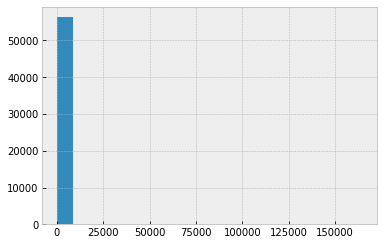

In [45]:
hist = pred_no_ac_yes_df['Project Cost'].hist(bins=20)

In [49]:
hist_no_ac_yes = pred_no_ac_yes_df.loc[pred_no_ac_yes_df['Project Cost']<10000]
hist_yes_ac_no = pred_yes_ac_no_df.loc[pred_yes_ac_no_df['Project Cost']<10000]

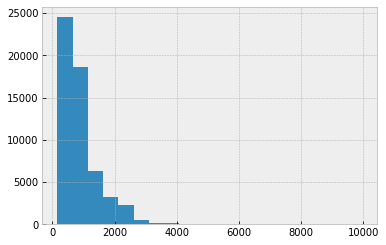

In [48]:
hist = hist_no_ac_yes['Project Cost'].hist(bins=20)

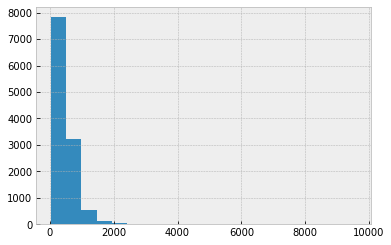

In [50]:
hist2 = hist_yes_ac_no['Project Cost'].hist(bins=20)